# DFT atom

In [1]:
using Pkg;
Pkg.activate("../../SchrodingerEquationSolver");
include("../src/SchrodingerEquationSolver.jl");
import .SchrodingerEquationSolver as ses
import .ses.Grids as Grids
import .ses.Potentials as Potentials
import .ses.MathUtils as MathUtils
import .ses.Hydrogen as Hydrogen
import .ses.InitialConditions as InitialConditions
import .ses.OneDSchrodingerEquationSolver as odses
import .ses.OneDPoissonEquationSolver as odpes
import .ses.EigenvalueFinders as EigenvalueFinders
import .ses.AtomBasisSet as AtomBasisSet
import .ses.Density as Density
import .ses.ExchangeCorrelation as ExchangeCorrelation
using Plots

import .ses.IntegralNumericalMethods as IntegralNumericalMethods 
#Define parameters and produce an exponential grid.
r_max::Float64=50.0;#Max radius of space grid.
Z::Int64=36;#Atomic number, also used as the charge of coulomb potential.

#grid definition
grid_stru= Grids.init_exponential_grid_structure(r_max, Z);
N=grid_stru.N;
print("grid size ", N)
#Initialization of potentials and energies

#Initializing coulomb potential due to nuclei charge.
V_colu::Vector{Float64}= Potentials.coulomb_potential(Z, grid_stru.grid);
#Initializing Hartree potential due to electron density. 
V_hartree::Vector{Float64}=zeros(Float64, N);
#Initializing exchange potential.
V_x::Vector{Float64}=zeros(Float64, N);
#Initializing correlation potential.
V_c::Vector{Float64}=zeros(Float64, N);
#Initializing energy exchange potential.
E_xp::Vector{Float64}=zeros(Float64, N);
#Initializing energy correlation potential.
E_cp::Vector{Float64}=zeros(Float64, N);
#Initializing exchange + correlation potential.
V_xcp::Vector{Float64}=zeros(Float64, N);
#Initializing the density.
density_in::Vector{Float64}= zeros(Float64, N);
#Initializing total energy
E_total::Float64=1.0;
#Initializing total energy step before
E_total_before::Float64=2.0;
#Initializing energy from energy eigenvalues
E_eigen::Float64=0.0;
#Initializing exchange correlation potential value after integral
V_xc::Float64= 0.0;
#Initializing Hartree energy
E_hartree::Float64= 0.0;
#Initializing exchange energy
E_x::Float64= 0.0;
#Initializing correlation enrgy
E_c::Float64= 0.0;
#Initializing basis set data structure
basis= AtomBasisSet.init_atom_basis_set(Z, grid_stru.grid);
runs=0;

  Activating project at `~/Desktop/physics_coding_projects/julia/SchrodingerEquationSolver`


grid size 8613

In [2]:
for i_orbi in basis.orbitals
    println(i_orbi.name)
    println(i_orbi.E)
end

1s
-648.0
2s
-162.0
2p
-162.0
3s
-72.0
3p
-72.0
4s
-40.5
3d
-72.0
4p
-40.5


In [3]:
for _ in 1:100
    runs+=1;
    println("&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&")
    println(runs)
    println("&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&")
    E_eigen=0.0;
    #Loop over every orbital to solve independent particle Schrodinger equation.
    for i_orbi in basis.orbitals
        println(i_orbi.name)
        #angular potential for l orbital
        V_angu= Potentials.angular_potential(i_orbi.l, grid_stru.grid);
        #Assemble effective potential.
        V_effe= V_colu .+ V_angu .+ V_hartree .+ V_x .+ V_c;
        V_effe_max= maximum(V_effe)
        V_effe_min= minimum(V_effe)
        energy_interval= EigenvalueFinders.guess_energy_interval(i_orbi.E, V_effe_max, V_effe_min);
        E_grid= Grids.uniform_grid(energy_interval[1], energy_interval[2], 100); #List with the energy grid points.

        E_intervals= EigenvalueFinders.find_eigenvalue_intervals(E_grid, V_effe, grid_stru,
                    InitialConditions.atom_exponential_grid,
                        odses.solver_exponential_grid);
        u_temp, ei_temp= EigenvalueFinders.illinois_eigenvalue_finder(E_intervals[1], V_effe, 
        grid_stru,InitialConditions.atom_exponential_grid, 
        odses.solver_exponential_grid ,
        l=i_orbi.l);
        #Update eigenvalue and eigenfunction in the basis set data structure.
        i_orbi.E=ei_temp;
        i_orbi.u=u_temp;
        E_eigen+= i_orbi.occu*ei_temp;
        println(i_orbi.E)
        #println("--------------------------------")

    end
    #for i_orbi in basis.orbitals
        #println(i_orbi.name)
        #println(i_orbi.E)
    #    Plots.display(plot(grid_stru.grid_i, i_orbi.u, title= string(i_orbi.name,i_orbi.E)))
    #end
    #Update E_total_before from the E_total from the previous step.
    E_total_before= float(E_total);
    #Calculate density with new basis set.
    density_out= Density.calculate_density(basis);
    #Smooth the density with linear mixing (combination) of the previous and current densities.
    density_in= Density.linear_mixing(density_in, density_out, alpha=0.10);
    #Solve Poisson equation to find the new Hartree potential.
    V_hartree= odpes.solver_exponential_grid(Z, density_in, grid_stru);
    #Calculate new exchange and correlation potentials.
    V_x, E_xp, V_c, E_cp= ExchangeCorrelation.potentials(density_in);
    #Add exchange and correlation potentials.
    V_xcp= V_x .+ V_c;
    #Integrals to calculate energy components.

    V_xc= 4.0*pi*MathUtils.energy_integral_exponential_grid(grid_stru, density_in, V_xcp)

    E_hartree= 0.5*4.0*pi*MathUtils.energy_integral_exponential_grid(grid_stru, density_in, V_hartree);

    E_x= 4.0*pi*MathUtils.energy_integral_exponential_grid(grid_stru, density_in, E_xp);

    E_c= 4.0*pi*MathUtils.energy_integral_exponential_grid(grid_stru, density_in, E_cp);

    #Calculate total energy.
    E_total= E_eigen - E_hartree + E_x + E_c - V_xc;

    println("*****************************************")
    println(E_total)
    println("*****************************************")


end

&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
1
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
1s
-648.0000000000316
2s
-162.00000000000543
2p
-161.99999999999616
3s
-71.99999999999852
3p
-72.00000000000394
4s
-40.49999999998558
3d
-72.00000000000168
4p
-40.50000000000038
*****************************************
-4230.521005263879
*****************************************
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
2
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
1s
-634.3632094331175
2s
-150.65534348899487
2p
-149.92004840274276
3s
-64.0255707392904
3p
-63.64349383608886
4s
-34.89287478789673
3d
-62.929413467070816
4p
-34.69252526847305
*****************************************
-3952.966013920691
*****************************************
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
3
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
1s
-618.3709447447601
2s
-139.23120928653276
2p
-137.69857599600263
3s
-

In [3]:
for _ in 1:4
    runs+=1;
    println("&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&")
    println(runs)
    println("&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&")
    E_eigen=0.0;
    #Loop over every orbital to solve independent particle Schrodinger equation.
    for i_orbi in basis.orbitals
        println(i_orbi.name)
        #angular potential for l orbital
        V_angu= Potentials.angular_potential(i_orbi.l, grid_stru.grid);
        #Assemble effective potential.
        V_effe= V_colu .+ V_angu .+ V_hartree .+ V_x .+ V_c;
        V_effe_max= maximum(V_effe)
        V_effe_min= minimum(V_effe)
        energy_interval= EigenvalueFinders.guess_energy_interval(i_orbi.E, V_effe_max, V_effe_min);

        u_temp, ei_temp= EigenvalueFinders.illinois_eigenvalue_finder(energy_interval, V_effe, 
        grid_stru,InitialConditions.atom_exponential_grid, 
        odses.solver_exponential_grid ,
        l=i_orbi.l);
        #Update eigenvalue and eigenfunction in the basis set data structure.
        i_orbi.E=ei_temp;
        i_orbi.u=u_temp;
        E_eigen+= i_orbi.occu*ei_temp;
        println(i_orbi.E)
        #println("--------------------------------")

    end
    #for i_orbi in basis.orbitals
        #println(i_orbi.name)
        #println(i_orbi.E)
    #    Plots.display(plot(grid_stru.grid_i, i_orbi.u, title= string(i_orbi.name,i_orbi.E)))
    #end
    #Update E_total_before from the E_total from the previous step.
    E_total_before= float(E_total);
    #Calculate density with new basis set.
    density_out= Density.calculate_density(basis);
    #Smooth the density with linear mixing (combination) of the previous and current densities.
    density_in= Density.linear_mixing(density_in, density_out, alpha=0.10);
    #Solve Poisson equation to find the new Hartree potential.
    V_hartree= odpes.solver_exponential_grid(Z, density_in, grid_stru);
    #Calculate new exchange and correlation potentials.
    V_x, E_xp, V_c, E_cp= ExchangeCorrelation.potentials(density_in);
    #Add exchange and correlation potentials.
    V_xcp= V_x .+ V_c;
    #Integrals to calculate energy components.

    V_xc= 4.0*pi*MathUtils.energy_integral_exponential_grid(grid_stru, density_in, V_xcp)

    E_hartree= 0.5*4.0*pi*MathUtils.energy_integral_exponential_grid(grid_stru, density_in, V_hartree);

    E_x= 4.0*pi*MathUtils.energy_integral_exponential_grid(grid_stru, density_in, E_xp);

    E_c= 4.0*pi*MathUtils.energy_integral_exponential_grid(grid_stru, density_in, E_cp);

    #Calculate total energy.
    E_total= E_eigen - E_hartree + E_x + E_c - V_xc;

    println("*****************************************")
    println(E_total)
    println("*****************************************")


end

&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
1
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
1s
-648.0000000000391
2s
-162.00000000000597
2p
-162.0000000000015
3s
-71.99999999999785
3p
-65.8476566737464
4s
-40.499999999985434
3d
-65.1920735846898
4p
-37.86680962069342
*****************************************
-4108.196844110218
*****************************************
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
2
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
1s
-635.4771762237735
2s
-151.32372540520242
2p
-150.6836349112394
3s
-64.33290454561428
3p
-63.97907880029814
4s
-35.009342326899244
3d
-63.310257969998304
4p
-34.8166234671752
*****************************************
-3965.8644750120043
*****************************************
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
3
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
1s
-619.3791255717641
2s
-139.8541211917106
2p
-138.4032157814199
3s
-56.

In [4]:
i_orbi = basis.orbitals[7];

In [8]:
float(sign(-.098))

-1.0

In [5]:
#println(i_orbi.name)
#angular potential for l orbital
V_angu= Potentials.angular_potential(i_orbi.l, grid_stru.grid);
#Assemble effective potential.
V_effe= V_colu .+ V_angu .+ V_hartree .+ V_x .+ V_c;
V_effe_max= maximum(V_effe)
println(V_effe_max)
V_effe_min= minimum(V_effe)
println(V_effe_min)


3.879547196878075e19
-67.23047644276299


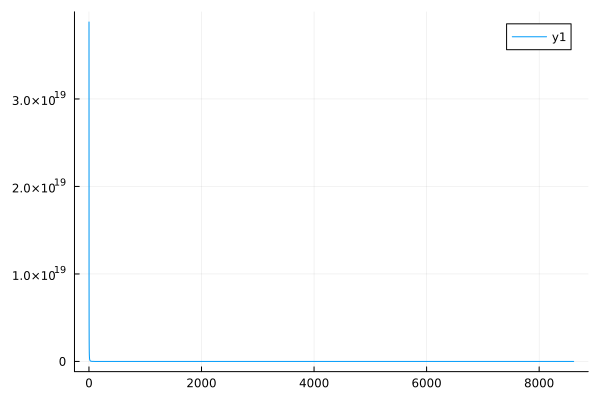

In [6]:
plot(grid_stru.grid_i, V_effe)

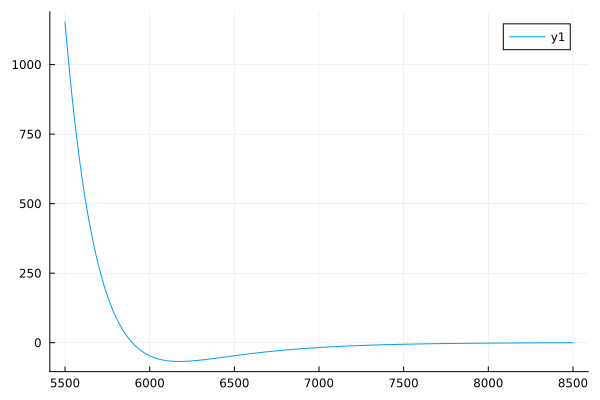

In [7]:
left=5500;
right=8500;

Plots.display(plot(grid_stru.grid_i[left: right], V_effe[left: right]))

In [8]:
energy_interval= EigenvalueFinders.guess_energy_interval(i_orbi.E, V_effe_max, V_effe_min);

In [9]:
energy_interval

(-51.79412204525562, -46.153178060128766)

In [10]:
0.5*(-51.79412204525562 + -46.153178060128766);

In [14]:
E_grid= Grids.uniform_grid(-65.0, -30.0, 300); #List with the energy grid points.

In [15]:
E_intervals= EigenvalueFinders.find_eigenvalue_intervals(E_grid, V_effe, grid_stru,
InitialConditions.atom_exponential_grid,
    odses.solver_exponential_grid);

In [16]:
E_intervals

1-element Vector{Tuple{Float64, Float64}}:
 (-40.53511705685619, -40.41806020066889)

In [17]:
E_interval= E_intervals[1];
v_effe= V_effe; 
initial_condition_function= InitialConditions.atom_exponential_grid;
solver=odses.solver_exponential_grid;
l=i_orbi.l;
N_max::Int64=1000;
tolerance::Float64=10.0e-12;
i=0;
Ec_befo=10.0e2;
Ea=E_interval[1];
Eb=E_interval[2];
Ec=0.0;
y0_0, y1_0, y0_end, y1_end, end_i=initial_condition_function(grid_stru, Ea, l);
_, u0a, _= solver(Ea, y0_0, y1_0, y0_end, y1_end, end_i, v_effe, grid_stru);
#init_valu1_fwrd, init_valu2_fwrd,
#init_valu1_bwrd, init_valu2_bwrd =initial_condition_function(grid, Ea, l);
#_, u0a= odses.solver(Ea,init_valu1_fwrd,init_valu2_fwrd, init_valu1_bwrd,
#    init_valu2_bwrd, v_effe, grid,integrador_type);
y0_0, y1_0, y0_end, y1_end, end_i=initial_condition_function(grid_stru, Eb, l);
_, u0b, _= solver(Eb, y0_0, y1_0, y0_end, y1_end, end_i, v_effe, grid_stru);
#init_valu1_fwrd, init_valu2_fwrd,
#init_valu1_bwrd, init_valu2_bwrd =initial_condition_function(grid, Eb, l);
#_, u0b= odses.solver(Eb,init_valu1_fwrd,init_valu2_fwrd, init_valu1_bwrd,
#    init_valu2_bwrd, v_effe, grid,integrador_type);
while i < N_max
    Ec=(Ea*u0b -Eb*u0a)/(u0b - u0a)
    if abs(Ec-Ec_befo) < tolerance
        break
    end
    y0_0, y1_0, y0_end, y1_end, end_i=initial_condition_function(grid_stru, Ec, l);
    _, u0c,_= solver(Ec, y0_0, y1_0, y0_end, y1_end, end_i, v_effe, grid_stru);
    #init_valu1_fwrd, init_valu2_fwrd,
    #init_valu1_bwrd, init_valu2_bwrd =initial_condition_function(grid, Ec, l);
    #_, u0c= odses.solver(Ec,init_valu1_fwrd,init_valu2_fwrd, init_valu1_bwrd,
    #    init_valu2_bwrd, v_effe, grid,integrador_type);
    if Integer(sign(u0c)) == Integer(sign(u0a))
        Ea=float(Ec)
        u0a=float(u0c)
        u0b=0.5*u0b
        #println(" 1  ", Ec)
    else
        Eb=float(Ec)
        u0b=float(u0c)
        u0a=0.5*u0a
        #println(" 2  ", Ec)
    end
    println(Ec)
    Ec_befo=Ec
    i+=1
end
y0_0, y1_0, y0_end, y1_end, end_i=initial_condition_function(grid_stru, Ec, l);
u, _, merge_ratio= solver(Ec, y0_0, y1_0, y0_end, y1_end, end_i, v_effe, grid_stru);

-40.50538307896425
-40.50577751740618
-40.50551612990127
-40.50562143366656
-40.50556412105826
-40.505591450472046
-40.505577476606824
-40.50558438360776
-40.50558091046814
-40.50558264208675
-40.50558177504513
-40.50558220825723
-40.505581991574154
-40.50558209989648
-40.50558204573038
-40.50558207281224
-40.50558205927113
-40.5055820660416
-40.50558206265624
-40.50558206434892
-40.50558206350258
-40.5055820639259
-40.50558206371418
-40.50558206381998
-40.50558206376705
-40.50558206379351
-40.50558206378026


In [12]:
E=-34.538473741014265;

v1, dv1, v_end, dv_end, end_i=InitialConditions.atom_exponential_grid(grid_stru, E, i_orbi.l);


a::Float64=grid_stru.a;
b::Float64=grid_stru.b;
grid_i::Vector{Float64}=grid_stru.grid_i;
f::Vector{Float64}= 2.0.*(V_effe .- E);
fv::Vector{Float64}= ((a*b.*exp.(b.*grid_i)).^2).*f .+ 0.25*b^2;
total_size=size(fv)[1];
gv=zeros(Float64, total_size);

#find turn_pnts of of f, basically the clasical turning points of the effective density_potential
#with restepect to the E proposed eigenvalue
turn_pnts= MathUtils.indices_of_zeros_finder(f);
if length(turn_pnts) ==  0
    throw(DomainError("the effective potential has no turning points 
    for the proposed energy eigenvalue, this means v_effe - E has no zeroes"));
end

#println("v1 ", v1)
#println("dv1 ", dv1)
#println("v_end ", v_end)
#println("dv_end ", dv_end)
#do forward integration of radial shcrodinger equation u
v_fwd= IntegralNumericalMethods.integrate_second_order_DE_RK4_PCABM5_direct_initial(grid_i,gv,fv,
v1,dv1);
v_bwd= zeros(Float64, total_size);
#do backward integreation of the radial shcrodinger equation u 
v_bwd_short= reverse(IntegralNumericalMethods.integrate_second_order_DE_RK4_PCABM5_direct_initial(reverse(grid_i[1:end_i]),gv[1:end_i],reverse(fv[1:end_i]),
v_end, dv_end));
v_bwd[1:end_i]= v_bwd_short;
#rescale u_fwd, u_bwd to make u_fwd[turn_pnts[1]] = u_bwd[turn_pnts[1]]
v_fwd, v_bwd= MathUtils.rescale!(v_fwd, v_bwd, turn_pnts[1]);
#merge solutions
v_merged, merge_value, merge_ratio= MathUtils.merge_solutions(v_fwd, v_bwd, grid_i, turn_pnts[1]);
v_merged= MathUtils.normalize_v!(v_merged, grid_stru);
u_merged= v_merged.*exp.((0.5*b).*grid_i);
println(merge_ratio)

5.341937184397297


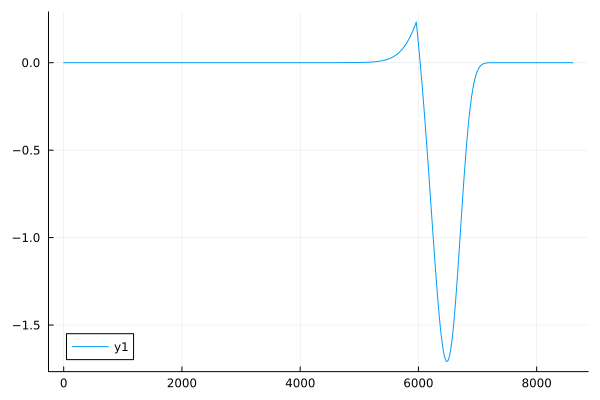

In [13]:
Plots.display(plot(grid_stru.grid_i, u_merged))

In [ ]:
u_temp, ei_temp= EigenvalueFinders.illinois_eigenvalue_finder(energy_interval, V_effe, 
grid_stru,InitialConditions.atom_exponential_grid, 
odses.solver_exponential_grid ,
l=i_orbi.l);

In [7]:
basis.orbitals[7].name

"3d"

In [8]:
basis.orbitals[7].u

8613-element Vector{Float64}:
  Inf
  Inf
  Inf
  Inf
  Inf
  Inf
  Inf
  Inf
  Inf
  Inf
   ⋮
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

In [10]:
density_in

8613-element Vector{Float64}:
  Inf
  Inf
  Inf
  Inf
  Inf
  Inf
  Inf
  Inf
  Inf
  Inf
   ⋮
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

In [11]:
V_x

8613-element Vector{Float64}:
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
 -Inf
   ⋮
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

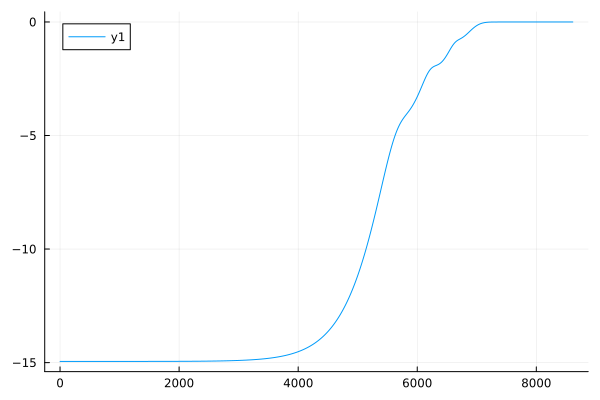

In [8]:
Plots.display(plot(grid_stru.grid_i, V_x))

In [9]:
E_xp

8613-element Vector{Float64}:
 -11.211261588655152
 -11.21126154800009
 -11.211261481509997
 -11.211261409728955
 -11.211261336017309
 -11.211261261398864
 -11.211261186336955
 -11.21126111088324
 -11.211261035127576
 -11.211260959104216
   ⋮
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0
  -0.0

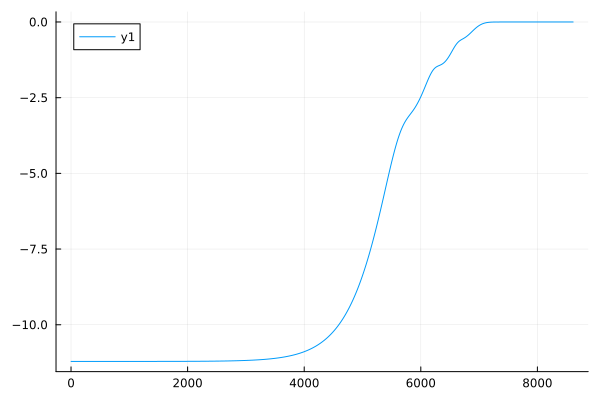

In [10]:
Plots.display(plot(grid_stru.grid_i, E_xp))

In [11]:
V_c

8613-element Vector{Float64}:
 -0.15997591484146892
 -0.15997591473333803
 -0.15997591455649332
 -0.1599759143655762
 -0.15997591416952425
 -0.15997591397106042
 -0.1599759137714171
 -0.1599759135707317
 -0.15997591336924322
 -0.1599759131670427
  ⋮
  5.664972651420499e-53
  5.664972651420499e-53
  5.664972651420499e-53
  5.664972651420499e-53
  5.664972651420499e-53
  5.664972651420499e-53
  5.664972651420499e-53
  5.664972651420499e-53
  5.664972651420499e-53

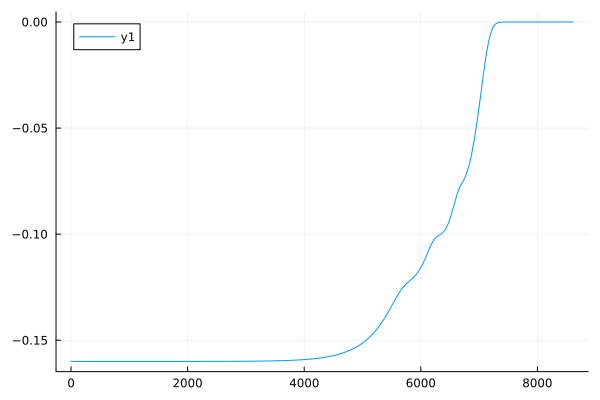

In [12]:
Plots.display(plot(grid_stru.grid_i, V_c))

In [14]:
E_cp

8613-element Vector{Float64}:
 -0.14769721480610637
 -0.14769721469777136
 -0.14769721452059287
 -0.14769721432931537
 -0.14769721413289336
 -0.1476972139340549
 -0.14769721373403474
 -0.14769721353297055
 -0.14769721333110172
 -0.14769721312851955
  ⋮
  5.664972651420499e-53
  5.664972651420499e-53
  5.664972651420499e-53
  5.664972651420499e-53
  5.664972651420499e-53
  5.664972651420499e-53
  5.664972651420499e-53
  5.664972651420499e-53
  5.664972651420499e-53

In [9]:
density_in

8391-element Vector{Float64}:
 6634.520755922213
 6634.520683746516
 6634.520565705412
 6634.520438271189
 6634.520307409528
 6634.520174938021
 6634.520041679217
 6634.519907724838
 6634.519773234406
 6634.519638268726
    ⋮
    1.4286931880793384e-201
    4.608164325059698e-202
    1.4824289724434197e-202
    4.756350532521354e-203
    1.522024567136706e-203
    4.8574632341554976e-204
    1.5461207725624011e-204
    4.908201102314834e-205
    1.5539923286907727e-205

In [10]:
V_x

8391-element Vector{Float64}:
 -18.503773897836005
 -18.503773830736318
 -18.50377372099687
 -18.503773602524905
 -18.50377348086655
 -18.503773357711562
 -18.503773233824646
 -18.503773109291075
 -18.503772984259143
 -18.50377285878539
   ⋮
  -1.1090985019379102e-67
  -7.606177333083744e-68
  -5.211728203196287e-68
  -3.5679197577639852e-68
  -2.440418722484365e-68
  -1.6677347114472871e-68
  -1.1386884941816966e-68
  -7.767797765965315e-69
  -5.294278106123729e-69

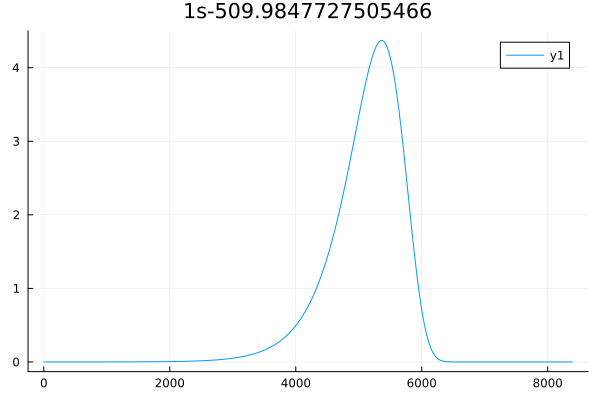

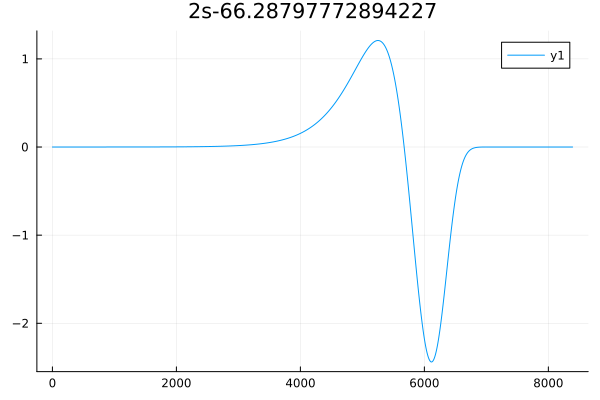

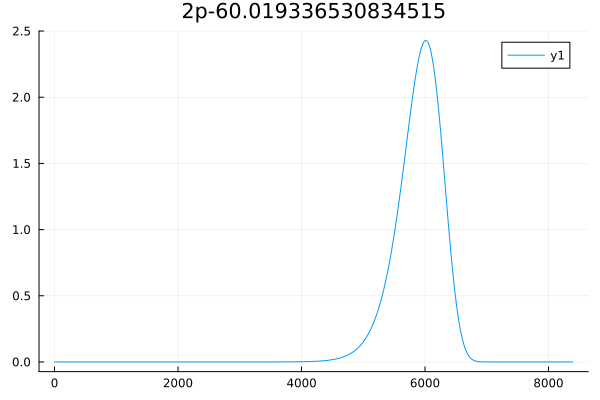

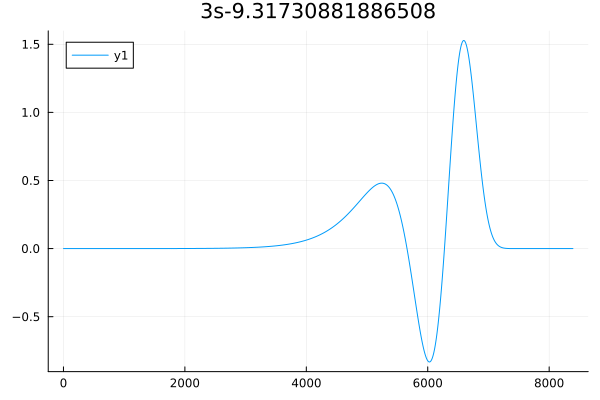

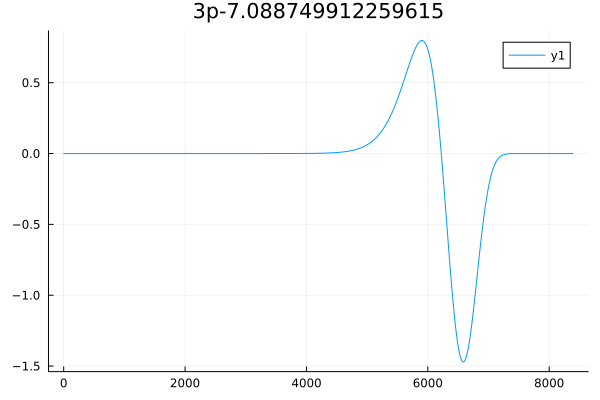

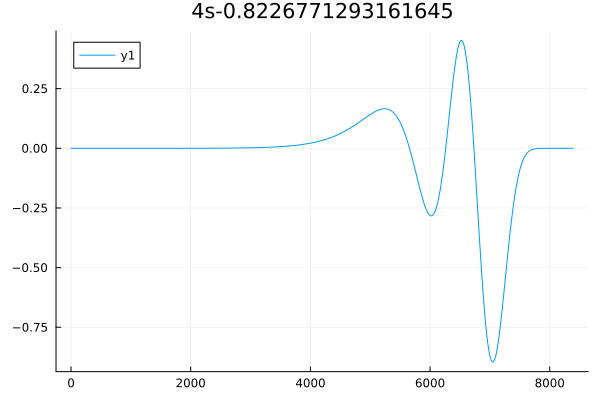

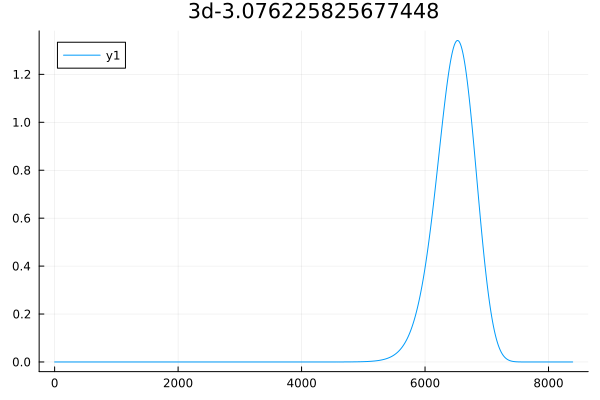

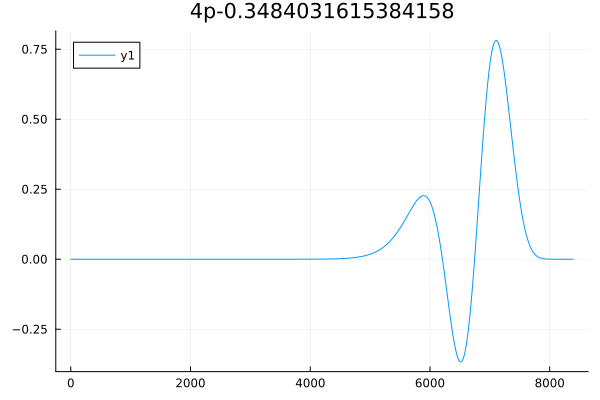

In [7]:
for i_orbi in basis.orbitals
    #println(i_orbi.name)
    #println(i_orbi.E)
    Plots.display(plot(grid_stru.grid_i, i_orbi.u, title= string(i_orbi.name,i_orbi.E)))
end